# Genetic Algorithm and Particle Swarm Optimization

## Importing Libraries

In [1]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import math
random.seed(40)
np.random.seed(40)

## Optimization Functions

In [2]:
def f1(x):
    """
        Function to calculate the Sphere function.
        
        Attributes:
            x - candidate solution
    """
    total = 0
    total = np.sum(np.square(x))
    return total

def f4(x):
    """
        Function to calculate the Griewank's function.
        
        Attributes:
            x - candidate solution
    """
    total = 0
    p1 = 0
    p2 = 1
    for i in range(len(x)):
        p1 += x[i]**2
        p2 *= np.cos(x[i]/(np.sqrt(i+1)))
    
    total = (p1/4000.0) - p2 + 1
    return total
    
    
def f6(x):
    """
        Function to calculate the Rastrigin's function.
        
        Attributes:
            x - candidate solution
    """
    total = 0
    for i in range(len(x)):
        total += x[i]**2 - (10 * np.cos(2 * np.pi * x[i])) + 10
        
    return total
    

## Genetic Algortihm

## Particle Swarm Optimization

In [3]:
class Particle:
    """
    Class that represents a candidate solution or a particle in the list of solutions/swarm.
    
    Attributes:
        n_dim - number of dimensions
        bounds - the maximum and minimum values for the positions and velocities and the initial range for the position
        pos - position of the particle
        vel - velocities of the particle along each dimension
        output - the output of the function run on the particle
        best_pos -  best position of the particle
        best_output - best function output of the particle
        informants - set of informants of the particle
        info_best_pos - best position found by one of its informants
    """
    def __init__(self, n_dim, bounds): 
        
        self.n_dim = n_dim # represents number of dimensions
        self.bounds = bounds # represents bounds asscociated with the acceptable values 
        self.pos = np.random.uniform(self.bounds[0], self.bounds[1], self.n_dim)  # represents the particle's position 
        self.vel = np.random.uniform(self.bounds[2], self.bounds[3], self.n_dim) # represents particle's velocity
        self.output = math.inf # represents the output of the objective function when run, for assessing the fitness of the solution
        self.best_pos = np.copy(self.pos) # represents the best solution/position of this particle
        self.best_output = self.output # represents the best (least) output value computed
        self.informants = np.array([]) # represents the list of informants
        self.info_best_pos = math.inf # represents the best solution/position found by one of its informants
        
    def update_velocity(self, info_best_pos, swarm_best_pos, weights):
        """
        Method to update the velocity of the particle.
        
        Attributes:
            info_best_pos - best position found by one of the informants
            swarm_best_pos - best position found by a particle in the swarm
            weights - the pweights for velocity update
        """
        alpha = weights[0] # inertia weight to decide the weight to give to the previous velocity value- between 0,1
        beta = weights[1]  # cognative weight
        gamma = weights[2]  # social weight
        delta =  weights[3] # global weight

        for i in range(self.n_dim):
            # to get 3 uniformly distributed random numbers between 0 and 1 (excluding 1)
            r1 = np.random.rand()
            r2 = np.random.rand()
            r3 = np.random.rand()
            
            # to calculate each of the components of the velocity update formula- personal velocity's update, difference between the current solution and its own best solution,
            # difference between the current solution and the best position found by the informants, and 
            # difference between the current solution and the best position found by the informants, and  best position found by any particle in the swarm
            personal_update = alpha * self.vel[i]
            own_best = beta * r1 * (self.best_pos[i]-self.pos[i])
            informant_best = gamma * r2 * (info_best_pos[i]-self.pos[i])
            global_best = delta * r3 * (swarm_best_pos[i]-self.pos[i])

            self.vel[i] = personal_update + own_best + global_best + informant_best # updating the velocity
            
            # Bounding the velocity calculated to be between the minimum and maximum velocties 
            # calculated depending on the position bounds given by the optimisation problem.
            # The velocity is set to the minimum/maximum depending on the direction of velocity.
            if self.vel[i] < self.bounds[2]:
                self.vel[i] = self.bounds[2]

            if self.vel[i] > self.bounds[3]:
                self.vel[i] = self.bounds[3]


    def update_position(self, eps):
        """
        Method to update the position of the particle.
        
        Attributes:
            eps - epsilon value in that iteration
        """
        for i in range(self.n_dim):
            self.pos[i] += eps * self.vel[i] # to update the position based on the velocity calculated.
            
            # Bounding the position calculated to be between the minimum and maximum position required by the optimisation problem.
            # The position is set to the minimum/maximum depending on its direction.
            if self.pos[i] < self.bounds[0]:
                self.pos[i] = self.bounds[0]
                
            if self.pos[i] > self.bounds[1]:
                self.pos[i] = self.bounds[1]


def get_bounds(funcname):
    """
        Function to get the lower and upper bounds of the position and velocity of a particle.
        
        Attributes:
            funcname - name of the function that will be optimized
    """
    min_bound = 0 # minimum position value
    max_bound = 0 # maximum position value
    
    if funcname == 'f1':
        min_bound = -100
        max_bound = 100
        
    elif funcname == "f4":
        min_bound = -600
        max_bound = 600
            
    elif funcname == "f6":
        min_bound = -5.12
        max_bound = 5.12
        
    # minimum and maximum permissible velocity values
    min_vel_bound = -0.2*(max_bound-min_bound)
    max_vel_bound = 0.2*(max_bound-min_bound)
    return (min_bound, max_bound, min_vel_bound, max_vel_bound)

def get_func(funcname, particle):
    """
        Function to get the right function and run it for a given particle.
        
        Attributes:
            funcname - name of the function that will be optimized
            particle - particle to run the function for
    """
    val = 0
    
    # depending on the function inputted, run the function on the position of the given particle
    if funcname == 'f1':
        val = f1(particle.pos)
        
    elif funcname == 'f4':
        val = f4(particle.pos)
            
    elif funcname == 'f6':
        val = f6(particle.pos)

    return val

def get_informants(particle, particles, num_informants):
    """
        Function to get the informants for the given particle and the best position found by them .
        
        Attributes:
            particle - particle for which informants are to be found
            particles - list of particles - the swarm
            num_informants - number of informants to select
    """
    ints = np.random.randint(0,len(particles),num_informants-1) # to get random numbers from 0 to num_informants-1
    informants = np.array([]) # to store the informants of the particle
    informants = np.append(informants,particle) # adding the particle itself as its informant
    informants = [particles[i] for i in ints if particles[i]!=particle] # to get the particle at the index given by ints

    info_best_pos = np.copy(informants[0].best_pos) # represents best position found by informants
    info_best_output = informants[0].best_output # represents best output calculated
            
    for p in informants: # iterating over the informants to find the best outpout and position 
        if p.best_output < info_best_output:
            info_best_output = p.best_output
            info_best_pos = np.copy(p.best_pos)

    return informants, info_best_pos # returning the list of informants the best position found

    
def PSO (funcname,n_dim,num_particles,num_informants,iterations, weights):
    """
    Function to update the position of the particle.
        
    Attributes:
        funcname - the name of the function to be optimized (optimization problem)
        n_dim - number of dimensions
        num_particles - number of particles that are to be present in the swarm
        num_informants - number of particles that are to be used as informants
        iterations - number of iterations for the algorithm to run in
        weights - the weights for velocity update in order of - [alpha,beta,gamma,delta]
        
    """
    bounds = get_bounds(funcname) # to obtain the bounds for the positions and velocities relative to the function
    particles = ([Particle(n_dim, bounds) for i in range(num_particles)]) # to get the particles for the swarm; to populate the swarm with Particle objects
    swarm_best = copy.deepcopy((particles[0])) # set the swarm best to be the first particle initially

    # epsilon to be used in computing the positions ranging from 0.4-0.9 
    # np.linspace returns iterations valued evenly spaced numbers from 0-iterations value
    eps = 0.9 - ((0.9-0.4)/iterations)*np.linspace(0,iterations,iterations)
    
    informants = np.array([]) # represents the list of informants
    info_best_pos = np.array([]) # represents the best position among the informants    
    best_outputs = np.array([]) # represents the best outputs from each iteration                         

    i = 0

    for i in range(iterations): # to run the optimization loop as many times as given by- iterations
        eps1 = eps[i] # to get the psilon value for this iteration
        for particle in particles: # to loop over the particles
            # to get the informants for this particle and the best postion found by them
            particle.informants, particle.info_best_pos = get_informants(particle, particles, num_informants)
            output = get_func(funcname, particle) # to get the output/fitness of the particle
            particle.output = output # to set the particle's current output to the output calculated
            
            # to check if this position is the best one found until now 
            # and set the best output and position to be that if that is the case
            if particle.best_output > output:
                particle.best_output = output
                particle.best_pos = copy.deepcopy(particle.pos)
                
            # if the output is the best found in the swarm, this particle is set as the swarm's best particle
            if particle.output < swarm_best.best_output:
                swarm_best = copy.deepcopy(particle)
        
        # the swarm best's position and output are the same as best position and output
        # to update the position and the velocity of all the particles
        for particle in particles:
            particle.update_velocity(particle.info_best_pos, swarm_best.best_pos, weights)
            particle.update_position(eps1)
                                                   
        # adding the swarm best's output in this iteration to the best_outputs list
        best_outputs = np.append(best_outputs,swarm_best.best_output) 
        i+=1

    print("Swarm-best output: ",swarm_best.output)
    print("Best postion: ",swarm_best.pos)
    plt.semilogy(best_outputs) # to print a graph of the best output with the iterations with the y axis scaled by log
    plt.xlabel('number of iterations', fontsize=10)
    plt.ylabel('best output', fontsize=10)
#     plt.show()
    return swarm_best # returning the best particle in the swarm

## Experimenting with Hyperparameter Values

### PSO
PSO (funcname,n_dim,num_particles,num_informants,iterations,weights)  

For each of the functions,
1. Calculate average best output from 10 runs  
2. Experiment with alpha  
3. Experiment with swarm sizes
4. Experiment with number of iterations

#### F1

alpha- 0.1
Swarm-best output:  7.464641694684801e-09
Best postion:  [-3.74744653e-05  1.86844420e-05 -1.75961371e-05  1.16688080e-05
 -4.14439838e-05  8.80528785e-06  4.33999975e-05 -4.69919674e-06
  2.23470904e-05 -3.26380312e-05]


alpha- 0.2
Swarm-best output:  2.2031810199544402e-10
Best postion:  [ 2.00106241e-06  7.28752202e-06  4.43353333e-07 -7.63903903e-06
 -2.60868983e-06 -3.32609695e-06  9.31019793e-07  8.77622991e-06
  2.64704118e-06  1.37490899e-06]


alpha- 0.3
Swarm-best output:  2.935624392320184e-17
Best postion:  [-5.14692257e-10 -1.69658060e-09  6.44697869e-10 -3.35720397e-10
 -3.18234949e-09 -2.87076923e-10 -3.33771331e-09 -1.04759065e-09
 -1.41159786e-09  1.11555379e-09]


alpha- 0.4
Swarm-best output:  3.1247474788608545e-19
Best postion:  [-8.34653190e-11 -1.74485678e-10  8.96554767e-11  3.59749573e-10
  2.66613766e-10 -3.13048782e-11  1.23969947e-10  1.23140897e-10
 -2.52881794e-12  1.87092645e-10]


alpha- 0.5
Swarm-best output:  2.5082466648388873e-16
Best pos

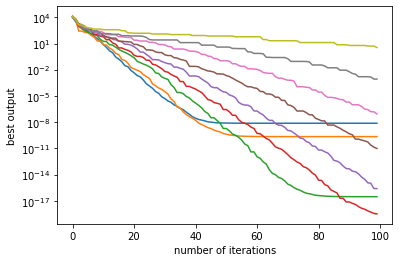

In [6]:
# output varies with alpha while the other parameters have been chosen after various considerations
a = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # increases until around 0.6 and decreases with increase in alpha after that
for alpha in a:
    print("alpha-",alpha)
    best = PSO ("f1",10,100,6,100,[alpha, 1.45, 1, 1.55])
    print('\n')

size- 30
Swarm-best output:  2.395487558876268e-12
Best postion:  [ 2.41989916e-09 -3.50035856e-07  2.29129656e-07 -4.72244941e-07
 -8.80882082e-08 -2.35747490e-07  6.49537242e-07  4.48269254e-07
  1.10214914e-06  3.10689269e-07]


size- 50
Swarm-best output:  1.3399390242920194e-14
Best postion:  [-7.71190283e-09  4.70141380e-08 -4.67754363e-08 -5.33553473e-08
  4.13992775e-08 -7.73393509e-09  3.45733134e-08 -2.34909300e-08
 -3.21951716e-08 -3.92106148e-08]


size- 100
Swarm-best output:  6.208728291106793e-16
Best postion:  [ 1.30037704e-08 -1.81453646e-08 -2.20477452e-09  3.37822055e-09
 -3.29044147e-09 -1.79809464e-09  7.05647222e-09 -8.92353979e-10
  6.44678075e-09 -1.89460158e-10]


size- 300
Swarm-best output:  4.30882655153478e-17
Best postion:  [ 2.67174014e-09 -1.48988865e-09 -2.74087993e-09  1.44328209e-09
  2.08412104e-10 -2.31125584e-09  1.06021407e-09  2.47926649e-09
  2.36980707e-09  2.42129616e-09]




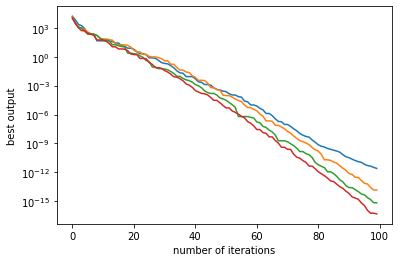

In [4]:
# checking with different swarm sizes
sizes = [30,50,100,300] # lesser values tested to avoid a dead kernel but other values were tested individually
for size in sizes:
    print("size-",size)
    best = PSO ("f1",10,size,6,100,[0.5, 1.45, 1, 1.55])
    print('\n')

iterations- 50
Swarm-best output:  1.0228464266334759e-06
Best postion:  [-7.56821894e-04 -2.04593413e-04  5.00133772e-06  1.37051583e-04
 -9.04620070e-05  2.19309731e-04 -3.75342437e-05  3.90043814e-04
 -1.40064989e-04  3.99948876e-04]


iterations- 100
Swarm-best output:  4.535475485212903e-16
Best postion:  [-1.61916636e-09 -9.28351832e-09 -4.36994569e-09 -5.69565801e-09
 -2.85823388e-09 -3.55674146e-09  1.04152508e-09  7.30022830e-09
 -1.54272291e-08  8.81798103e-11]


iterations- 200
Swarm-best output:  6.180647159262217e-35
Best postion:  [-2.27419562e-18 -6.04553206e-19  1.85714711e-18  4.66741700e-18
 -3.01611921e-18  2.61175955e-18 -1.50718217e-18 -1.89614150e-18
 -1.76791238e-18 -2.47477606e-18]


iterations- 300
Swarm-best output:  2.1227870472674575e-53
Best postion:  [-9.95422243e-28 -2.41143037e-28  1.46088493e-27 -1.41032890e-27
 -5.99905535e-28 -2.91275065e-27 -1.73556017e-27 -1.04943918e-27
 -2.06184495e-28 -1.74803773e-27]


iterations- 500
Swarm-best output:  4.63225

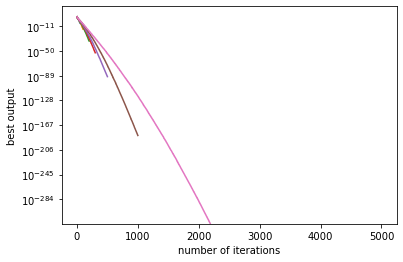

In [5]:
# checking with different number of iterations
iters = [50,100,200,300,500,1000,5000]
for iter1 in iters:
    print("iterations-",iter1)
    best = PSO ("f1",10,100,6,iter1,[0.5, 1.45, 1, 1.55])
    print('\n')

dimensions- 1
Swarm-best output:  4.04121889047473e-28
Best postion:  [2.01027831e-14]


dimensions- 2
Swarm-best output:  1.5462969720549478e-25
Best postion:  [-3.25393847e-13 -2.20790719e-13]


dimensions- 3
Swarm-best output:  4.519684520652508e-24
Best postion:  [-5.47663389e-15  1.18181781e-12 -1.76719020e-12]


dimensions- 5
Swarm-best output:  1.7185823246037034e-20
Best postion:  [ 4.95624591e-11  7.95569365e-11 -2.10299184e-11 -6.28376531e-11
 -6.33186516e-11]


dimensions- 7
Swarm-best output:  1.6574726335347781e-18
Best postion:  [ 1.69176757e-10 -2.63634657e-10 -1.26506399e-10  5.52252155e-10
 -7.93004475e-10  2.80527223e-10  7.28567563e-10]


dimensions- 9
Swarm-best output:  1.042755783122646e-16
Best postion:  [ 1.46870728e-09  5.78567961e-09  7.72963482e-09  9.17146099e-10
 -1.72195682e-09 -4.37801573e-10 -1.13184364e-09 -1.81222294e-09
  5.77883823e-10]


dimensions- 10
Swarm-best output:  4.740361819108509e-16
Best postion:  [ 4.15893905e-09 -1.03529800e-08  8.58117

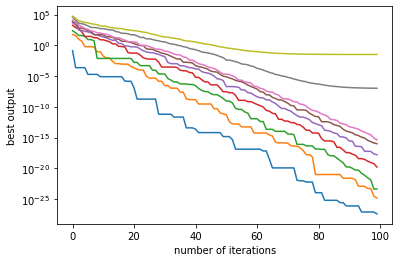

In [10]:
# checking with different dimensions
dims = [1,2,3,5,7,9,10,20,30]
for dim in dims:
    print("dimensions-",dim)
    best = PSO ("f1",dim,100,6,100,[0.5, 1.45, 1, 1.55])
    print('\n')

Swarm-best output:  1.4764111270367323e-07
Best postion:  [-1.94145813e-05  1.31705141e-05 -1.92531713e-04  5.94632943e-06
  1.85207416e-04 -9.75519115e-05  2.05268009e-04 -1.19229078e-04
  7.78805052e-05 -6.12604337e-05]
Swarm-best output:  5.355846777508656e-08
Best postion:  [ 1.50212196e-04 -2.95751048e-05  5.09906293e-05 -3.88294845e-05
  1.01811719e-04 -5.94920199e-05 -6.95085453e-06 -2.40416290e-05
  6.89942572e-06  1.06927363e-04]
Swarm-best output:  4.738952136363369e-08
Best postion:  [-3.58018773e-05  1.47470862e-04 -3.14088538e-05  2.49913849e-05
 -6.18022113e-05 -8.79432700e-05  1.73481360e-05  9.02096144e-06
 -2.57246557e-05  1.00754061e-04]
Swarm-best output:  1.250584021550981e-08
Best postion:  [ 3.60677539e-05  2.74440830e-05  2.14952882e-05 -1.34655770e-05
 -6.30435298e-05 -2.54704682e-05  9.13351328e-06  1.64039688e-05
 -6.66000835e-05 -1.99272852e-05]
Swarm-best output:  7.011735474838173e-08
Best postion:  [ 1.19206651e-04 -3.97373859e-05 -5.11246562e-05 -4.405898

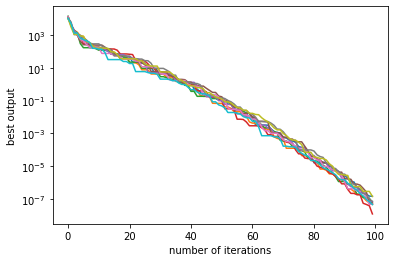

In [9]:
# Calculating average best output values after running the algorithm with the same parameters mutliple times
avg = 0
n = 10
for i in range(n):
    best = PSO ("f1",10,300,6,100,[0.5, 1.45, 1, 1.55])
    avg += best.output
print("Average swarm-best output:",avg/n)

#### F4

alpha- 0.1
Swarm-best output:  0.33874088127785407
Best postion:  [-3.12221060e+00  4.49035145e+00 -4.74205789e-02 -9.09131211e-01
  8.00931969e-01  1.16260294e-01 -8.27097086e+00 -7.67462547e-02
 -4.13197205e-02 -9.06782284e+00  6.74910059e-01  1.28556372e+00
 -5.39481449e-03 -9.48480289e-03  1.84032431e-01 -1.97663610e-01
 -2.12476157e-01  1.19710303e-01  1.07696407e+00  4.87896193e-01]


alpha- 0.2
Swarm-best output:  0.15252483896747604
Best postion:  [-1.24725163e+01  6.91576284e-02 -3.01680987e-02  9.12476259e-02
 -6.92831756e-02  1.03996986e-01  1.49489994e-02 -9.68145516e-01
  8.75143631e-02  1.61572446e-01  1.53623671e-01  9.30941136e-02
  1.98987620e-04 -1.90495878e-06 -5.76988136e-01  4.30415742e-01
 -6.75380479e-02 -6.03149947e-02 -7.37991142e-01  8.25611184e-01]


alpha- 0.3
Swarm-best output:  1.0991896282064317e-10
Best postion:  [ 1.72309138e-06 -3.76406901e-06  1.43777071e-05 -3.13440515e-06
  5.27103491e-06 -3.57814689e-06 -1.63277303e-05  1.60759547e-08
 -6.73881410e

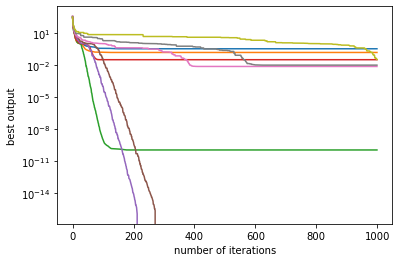

In [15]:
# checking with different alpha values
a = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for alpha in a:
    print("alpha-",alpha)
    best = PSO ("f4",20,100,6,1000,[alpha,1.55,1,1.45])
    print('\n')

size- 30
Swarm-best output:  0.027093396087305877
Best postion:  [-3.14002257e+00 -4.43844431e+00 -5.43324790e+00  1.27083940e-08
  7.00729600e+00  2.45030395e-08  6.92729594e-09  8.27731663e-09
 -2.76875429e-08  4.10831085e-09 -2.05245768e-08 -2.39571191e-08
  1.92985129e-08 -1.13893231e-08  2.76888189e-08  1.93964327e-08
  3.65624358e-08  2.04132734e-08  3.33462211e-08 -2.33526756e-09]


size- 50
Swarm-best output:  0.02958416121206986
Best postion:  [-6.28004522e+00 -8.87688888e+00 -6.20172178e-10 -1.40998064e-08
 -1.26211422e-08  4.69213328e-09 -1.91453375e-08  1.48264472e-08
  8.00443162e-09 -2.98997857e-08 -1.37039698e-08 -3.59202748e-08
  9.39410140e-09  6.40844682e-09 -2.76885438e-08  3.50799514e-09
  1.95799120e-08  1.64240038e-08 -2.69532370e-08  1.21561179e-08]


size- 100
Swarm-best output:  0.04412660136317692
Best postion:  [-5.20401737e-09  1.27138767e-08  5.43324597e+00 -1.88707747e-08
 -2.67715200e-09 -2.21421090e-08  6.71886686e-09  1.77992194e-08
 -3.94223634e-10 -2.

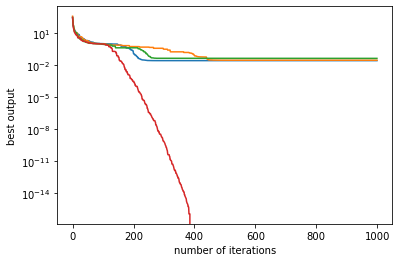

In [11]:
# checking with different swarm sizes
sizes = [30,50,100,300]
for size in sizes:
    print("size-",size)
    best = PSO ("f4",20,size,6,1000,[0.7, 1.55,1,1.45])
    print('\n')

iterations- 50
Swarm-best output:  0.593779820468719
Best postion:  [ 0.10704762 -4.69516144  0.65657335  6.43971734 -1.50276239 -0.13390901
 -0.43996111 -0.35463364 -0.54507116  0.9756405   0.50052977 -0.20297773
  1.16517174  1.11066684 -0.09038989 -1.6270323  -2.45794194 -0.90481625
  0.63895164  0.20977696]


iterations- 100
Swarm-best output:  0.024755197492540182
Best postion:  [ 6.27786812e+00 -4.44035353e+00  3.82002926e-03 -6.26657398e+00
 -4.10468841e-05 -1.24279144e-02  5.15444495e-03 -1.02969229e-02
 -1.97862605e-02 -1.45469517e-03  3.55595608e-03 -4.24851489e-04
  1.34577482e-02  1.56917675e-02 -2.11842284e-02  3.92662421e-03
  2.83656236e-02 -6.13064088e-04 -9.69646495e-03  6.78055908e-03]


iterations- 200
Swarm-best output:  0.0270174201113349
Best postion:  [ 3.14002166e+00 -5.55580520e-07  2.16888751e-06  1.94649554e-07
 -1.03272400e-06  4.76172175e-10  2.54932560e-06  2.04009111e-07
 -3.17173027e-07 -9.88515890e+00 -2.66047398e-06 -2.25345822e-06
  1.11158612e-06  2.

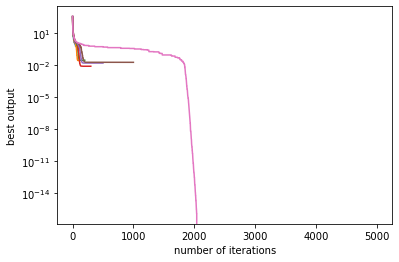

In [12]:
# checking with different number of iterations
iters = [50,100,200,300,500,1000,5000]
for iter1 in iters:
    print("iterations-",iter1)
    best = PSO ("f4",20,100,6,iter1,[0.7, 1.55,1,1.45])
    print('\n')

dimensions- 1
Swarm-best output:  0.0
Best postion:  [-1.31536292e-09]


dimensions- 2
Swarm-best output:  0.0
Best postion:  [1.38778227e-09 7.76050404e-09]


dimensions- 3
Swarm-best output:  0.0
Best postion:  [ 9.10938253e-09  1.40417253e-08 -1.77551580e-09]


dimensions- 5
Swarm-best output:  0.04967387738658058
Best postion:  [-3.03024409 -4.57020767 -0.05341192  0.03621959 -0.56334282]


dimensions- 7
Swarm-best output:  0.10253096612681156
Best postion:  [-9.45838172e+00 -3.17737524e-02 -5.65168420e+00 -6.00308690e-03
  1.43419360e+01 -2.06769809e-01  9.29293420e-02]


dimensions- 9
Swarm-best output:  0.07377374102945222
Best postion:  [ 3.14002226e+00  4.43844340e+00 -6.32917877e-09 -6.27064108e+00
  6.61266361e-10  7.67227713e+00  3.58878926e-09 -8.85035756e+00
  9.38254881e+00]


dimensions- 10
Swarm-best output:  0.06154607306682158
Best postion:  [ 9.42005392e+00 -4.43840896e+00 -1.92097252e-05  8.60183245e-05
  5.84441393e-05  7.67222949e+00 -9.68925861e-05 -8.85034689e+

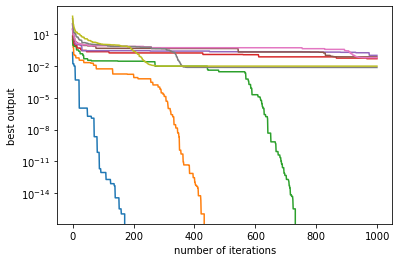

In [13]:
# checking with different dimensions
dims = [1,2,3,5,7,9,10,20,30]
for dim in dims:
    print("dimensions-",dim)
    best = PSO ("f4",dim,100,6,1000,[0.7, 1.55,1,1.45])
    print('\n')

Swarm-best output:  0.012320988875106575
Best postion:  [ 5.50266633e-09  4.43844443e+00  5.43324815e+00 -1.09037658e-08
 -1.29443131e-08  1.79906108e-08  1.21232377e-08  8.33036092e-10
  1.34514657e-08 -7.89996447e-09 -1.49568759e-09 -1.27181053e-08
 -2.67454439e-08  2.22959999e-08 -2.41972187e-09  2.56128716e-08
 -2.05930750e-08  2.25665569e-08  2.93616038e-08 -2.87727062e-08]
Swarm-best output:  0.0
Best postion:  [ 2.28195975e-09  5.87051463e-09 -1.49721498e-08  1.88497709e-08
  1.08490751e-08 -1.90654624e-08  1.67533630e-08 -2.45599375e-08
 -7.09498663e-09 -5.37355663e-09  1.41940353e-08  2.79891929e-08
  2.70333100e-08 -9.38520371e-09  1.16019486e-09  4.80969159e-09
 -2.74323581e-08 -2.65680172e-08 -2.23671445e-08 -1.52350748e-08]
Swarm-best output:  0.0
Best postion:  [ 2.54129140e-09  1.22218010e-08 -1.38116040e-08 -1.95411329e-08
  1.90857720e-08 -2.09110413e-09 -2.08545597e-08  7.19695969e-09
  2.63201321e-08  3.98496410e-09 -2.22243027e-08  8.53708908e-09
  1.72614166e-08 -3

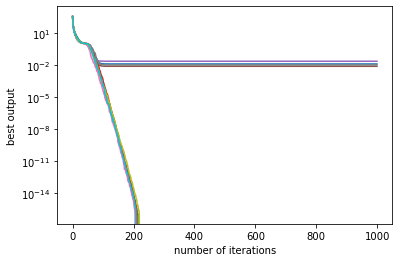

In [14]:
# Calculating average best output values after running the algorithm with the same parameters mutliple times
avg = 0
n = 10
for i in range(n):
    best = PSO ("f4",20,100,6,1000,[0.5,1.55,1,1.45])
    avg += best.output
print("Average swarm-best output:",avg/n)

#### F6

alpha- 0.1
Swarm-best output:  4.974795285508112
Best postion:  [ 9.94958939e-01  1.05968099e-07 -9.94958639e-01 -9.94958832e-01
  1.64455416e-09  9.94958622e-01 -2.64431866e-07 -2.93260792e-10
  7.18766159e-10  9.94958637e-01]


alpha- 0.2
Swarm-best output:  5.969754342560327
Best postion:  [ 1.54253053e-09  3.26013008e-09  9.94958639e-01  9.94958685e-01
 -9.94958634e-01  2.35140175e-08  9.94958641e-01 -9.94958638e-01
  9.94958640e-01 -1.04239945e-08]


alpha- 0.3
Swarm-best output:  4.974795285466451
Best postion:  [-9.08286456e-10  9.94958639e-01 -9.94958637e-01  9.94958635e-01
  7.88269290e-10 -2.67115167e-10 -2.58210517e-10 -9.94958639e-01
 -9.94958637e-01 -1.19768255e-09]


alpha- 0.4
Swarm-best output:  1.9899181141865796
Best postion:  [-4.49008806e-10  1.37707701e-09  9.94958638e-01  3.16228040e-10
 -9.64557288e-10  2.66771854e-11 -7.99842780e-10  1.51456174e-09
 -1.53913722e-09  9.94958638e-01]


alpha- 0.5
Swarm-best output:  2.9848771712798694
Best postion:  [ 9.94958638e-

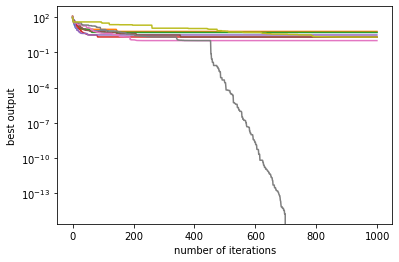

In [17]:
# checking with different alpha values
a = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for alpha in a:
    print("alpha-",alpha)
    best = PSO ("f6",10,300,6,1000,[alpha, 2, 0.001, 1.999])
    print('\n')

size- 30
Swarm-best output:  9.949585533113831
Best postion:  [-1.71047290e-10 -1.68562596e-10  9.94958640e-01 -9.94958639e-01
  9.94958638e-01  1.98991223e+00  1.05183072e-09  9.94958638e-01
 -9.94958638e-01  9.94958638e-01]


size- 50
Swarm-best output:  7.959667418927248
Best postion:  [ 1.63482955e-09 -1.40001505e-09 -1.26348835e-09 -4.35644849e-10
 -9.94958638e-01 -9.94958636e-01  9.94958637e-01  1.98991223e+00
  9.94958638e-01 -2.84104371e-10]


size- 100
Swarm-best output:  1.9899181141865796
Best postion:  [ 5.00030309e-10  4.47998806e-10  9.94958636e-01 -1.01079293e-09
 -9.94958638e-01  8.78382355e-10 -8.95529638e-10 -1.08179072e-09
  3.71236324e-10  4.22086090e-10]


size- 300
Swarm-best output:  0.0
Best postion:  [ 1.04533127e-09  1.25070753e-09  8.08417977e-10  1.26896144e-09
  1.44665572e-09  1.24489945e-09 -4.05217668e-10 -9.71752730e-10
 -1.56277563e-09 -7.93819236e-10]




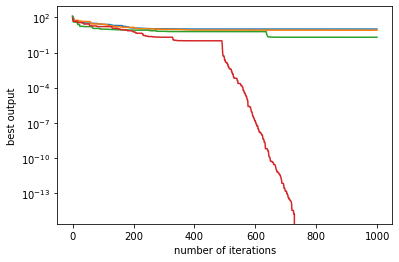

In [18]:
# checking with different swarm sizes
sizes = [30,50,100,300]
for size in sizes:
    print("size-",size)
    best = PSO ("f6",10,size,6,1000,[0.8, 2, 0.001, 1.999])
    print('\n')

iterations- 50
Swarm-best output:  7.971940839992044
Best postion:  [ 0.02245799  0.98481597  0.0166058   0.98553805 -1.03043944 -0.03837211
 -0.98572502 -0.07956089  1.00058479 -0.98580475]


iterations- 100
Swarm-best output:  5.043114220444481
Best postion:  [ 0.99046124 -0.00270146 -0.99289753  0.00618507 -0.00521455  1.0083398
 -0.99542483 -0.99727658  0.00774699 -0.0016    ]


iterations- 200
Swarm-best output:  2.9983758766082804
Best postion:  [-1.39983709e-03 -9.93926355e-01 -1.26946571e-03 -9.88464040e-01
 -9.95357661e-01 -5.03612535e-04 -3.48919797e-03 -2.19232158e-03
  5.06293606e-04 -1.90272230e-03]


iterations- 300
Swarm-best output:  1.9900603695333299
Best postion:  [-2.55945196e-04 -9.38421665e-06 -9.81843138e-05 -9.94350049e-01
  2.82896488e-04 -9.95269267e-01 -1.07903355e-04 -1.45906524e-04
  5.50958591e-06  2.49374754e-04]


iterations- 500
Swarm-best output:  0.9949590570933502
Best postion:  [-1.72657834e-09  3.37589699e-09 -1.10896824e-09 -9.94958630e-01
 -6.689

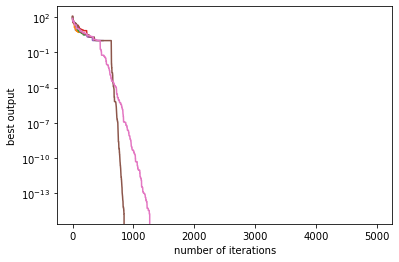

In [21]:
# checking with different number of iterations
iters = [50,100,200,300,500,1000,5000]
for iter1 in iters:
    print("iterations-",iter1)
    best = PSO ("f6",10,300,6,iter1,[0.8, 2, 0.001, 1.999])
    print('\n')

dimensions- 1
Swarm-best output:  0.0
Best postion:  [7.1363242e-10]


dimensions- 2
Swarm-best output:  0.0
Best postion:  [1.00150044e-09 1.36587099e-09]


dimensions- 3
Swarm-best output:  0.0
Best postion:  [-1.36714240e-09  8.90455227e-10  1.64140990e-09]


dimensions- 5
Swarm-best output:  0.0
Best postion:  [-1.27081383e-09  2.14246349e-11 -2.66991517e-10 -1.25578700e-09
 -1.33463036e-09]


dimensions- 7
Swarm-best output:  0.0
Best postion:  [-4.20105922e-10 -5.18931250e-10 -1.41327305e-09 -1.43080062e-09
 -1.24102825e-09  7.45507804e-10  1.52753325e-09]


dimensions- 9
Swarm-best output:  0.9949590570932898
Best postion:  [ 1.32242864e-09 -1.32186874e-09 -9.94958638e-01  6.49991279e-10
  3.31589450e-10 -1.44544887e-09  6.74693451e-10 -1.66198385e-11
 -7.37781838e-10]


dimensions- 10
Swarm-best output:  0.0
Best postion:  [-1.12585980e-09 -3.23628882e-10  1.11681867e-09  7.11276160e-10
  2.63817281e-10 -7.61172485e-10  6.14675277e-10  1.14584104e-09
 -7.99896467e-11 -7.0594449

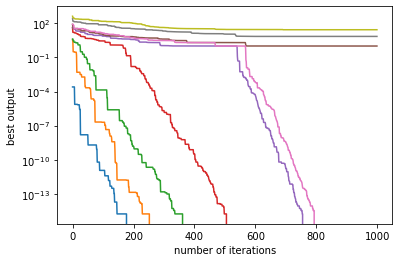

In [19]:
# checking with different number of dimensions
dims = [1,2,3,5,7,9,10,20,30]
for dim in dims:
    print("dimensions-",dim)
    best = PSO ("f6",dim,300,6,1000,[0.8, 2, 0.001, 1.999])
    print('\n')

Swarm-best output:  0.0
Best postion:  [-1.30585411e-09 -1.54003461e-09 -3.48769707e-10 -3.29801720e-10
 -3.77455760e-10  1.50946057e-09  3.45809672e-10 -1.53322147e-11
 -5.35035459e-10  6.72957985e-10]
Swarm-best output:  0.9949590570932898
Best postion:  [ 1.37323223e-09 -3.34303231e-12  1.09251249e-10 -1.37102606e-10
 -7.63442336e-10 -7.08631600e-10 -1.37553639e-09  1.61686748e-09
  1.61623037e-09 -9.94958637e-01]
Swarm-best output:  0.0
Best postion:  [-7.27201015e-10  1.08691882e-09 -1.69097224e-10 -7.22202501e-10
 -1.20223142e-09 -7.10373872e-11  1.12221196e-09 -9.11819795e-10
  6.94241320e-10  7.34723725e-10]
Swarm-best output:  0.9949590570932898
Best postion:  [ 1.52115227e-09  5.57315237e-10 -1.44615189e-09  4.24467095e-10
 -1.11865884e-09 -3.71125327e-10 -9.94958638e-01  7.06534113e-10
  9.59988129e-10 -9.65327326e-11]
Swarm-best output:  0.9949590570932898
Best postion:  [ 1.01406240e-09 -1.27106496e-09 -9.94958639e-01 -1.43829718e-09
  1.49502999e-09 -1.37583888e-09 -1.085

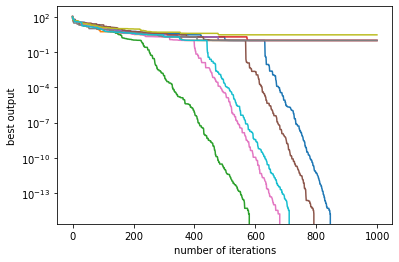

In [20]:
# Calculating average best output values after running the algorithm with the same parameters mutliple times
avg = 0
n = 10
for i in range(n):
    best = PSO("f6",10,300,6,1000,[0.8, 2, 0.001, 1.999])
    avg += best.output
print("Average swarm-best output:",avg/n)

### Swarm size, number of iterations and alpha values affect the most while the other values are equally influencing. The fixed values work the best in all cases but those of the mentioned variables, vary with the different combinations.

In [ ]:
# # Run f1/f4/f6 for one set of values
# PSO ("f1",10,300,6,5000)
# print("--------------------------------------------------------------")
# PSO ("f4",10,300,6,5000)
# print("--------------------------------------------------------------")
# PSO ("f6",10,300,6,5000) 